In [72]:
import torch 
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import cv2 as cv
import numpy as np

import requests
import copy
from tqdm import tqdm
import pickle



from PIL import Image
from pathlib import Path
import os
import random
from imutils.paths import list_images
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
class SolarDataset(VisionDataset):
    """A dataset directly read images and masks from folder.    
    """
    def __init__(self, 
                 root, 
                 image_folder, 
                 mask_folder,
                 transforms,
                 mode = "train",
                 random_seed=42):
        super().__init__(root, transforms)
        self.image_path = Path(self.root) / image_folder
        self.mask_path = Path(self.root) / mask_folder

        self.image_list = sorted(list(list_images(self.image_path)))
        self.mask_list = sorted(list(list_images(self.mask_path)))

        self.image_list = np.array(self.image_list)
        self.mask_list = np.array(self.mask_list)

        np.random.seed(random_seed)
        index = np.arange(len(self.image_list))
        np.random.shuffle(index)
        self.image_list = self.image_list[index]
        self.mask_list = self.mask_list[index]

    def __len__(self):
        return len(self.image_list)

    def __getname__(self, index):
        image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
        mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

        if image_name == mask_name:
            return image_name
        else:
            return False
    
    def __getitem__(self, index):
        if not self.__getname__(index):
            raise ValueError("{}: Image doesn't match with mask".format(os.path.split(self.image_list[index])[-1]))
        image = Image.open(self.image_list[index])
        mask = Image.open(self.mask_list[index]).convert('L')
        mask = np.array(mask) - 1 # note that we need to transform the lowest label to 0
        mask = Image.fromarray(mask)

        image, mask = self.transforms(image, mask)

        return image, mask



In [16]:
class Compose:
    def __init__(self, transforms):
        """
        transforms: a list of transform
        """
        self.transforms = transforms
    
    def __call__(self, image, target):
        """
        image: input image
        target: input mask
        """
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class FixResize:
    # UNet requires input size to be multiple of 16
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        return image, target

class ToTensor:
    """Transform the image to tensor. Scale the image to [0,1] float32.
    Transform the mask to tensor.
    """
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

class PILToTensor:
    """Transform the image to tensor. Keep raw type."""
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std
    
    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [17]:
root = Path('data/train_val_test/train_val_upsample_aug/')
transformers = Compose([FixResize(256), ToTensor(), Normalize()])

trainset = SolarDataset(root, image_folder="train/img", 
        mask_folder="train/masks_machine", transforms=transformers)
trainloader = DataLoader(trainset, shuffle=True, batch_size=30)

valset = SolarDataset(root, image_folder="val/img", 
        mask_folder="val/masks_machine", transforms=transformers)
valloader = DataLoader(valset, shuffle=False, batch_size=30)

In [20]:
val_names = [valset.__getname__(i) for i in range(valset.__len__())]

In [23]:
with open('val_names.pkl', 'wb') as f:
    pickle.dump(val_names, f)

In [14]:
def DeepLab_pretrained(num_classes):
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    deeplab.classifier = DeepLabHead(2048, num_classes)
    return deeplab

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeepLab_pretrained(5).to(device)

In [16]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)


In [9]:
from collections import defaultdict

In [14]:
#model.load_state_dict(torch.load("output/weights_epoch14.pth"))

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [17]:
num_epoch = 10
valmasks = defaultdict(list)

best_loss = float('inf')
#best_wts = copy.deepcopy(model.state_dict())
record = {
   'trainloss': [],
   'valloss': []
}


#torch.autograd.set_detect_anomaly(True)
for epoch in range(15, 15+num_epoch):
    print('Epoch {}/{}'.format(epoch, 15+num_epoch-1))
    print('-'*10)

    model.train()
    minibatch_loss = 0
    for img, target in tqdm(trainloader):
        img, target = img.to(device), target.to(device)
        output = model(img)['out']
        loss = criterion(output, target)
        minibatch_loss += loss.item() * img.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()
    record['trainloss'].append(minibatch_loss / trainset.__len__())

    minibatch_loss = 0
    model.eval()
    with torch.no_grad():
        for img, target in tqdm(valloader):
            img, target = img.to(device), target.to(device)
            output = model(img)['out']
            loss = criterion(output, target)
            minibatch_loss += loss.item() * img.shape[0]
            valmasks[epoch].append(output.to('cpu'))
    record['valloss'].append(minibatch_loss / valset.__len__())

    print('train loss: {:.4f}, val loss: {:.4f} \n'.format(
        record['trainloss'][-1], record['valloss'][-1]
    ))

    torch.save(model.state_dict(), "output/weights_epoch{}.pth".format(epoch))

    if record['valloss'][-1] < best_loss:
        best_loss = record['valloss'][-1]
        best_wts = copy.deepcopy(model.state_dict())

torch.save(best_wts, "output/weights_best.pth")
with open('output/record.pkl', 'wb') as file:
    pickle.dump(record, file)

Epoch 15/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


train loss: 0.0492, val loss: 0.0618 

Epoch 16/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


train loss: 0.0488, val loss: 0.0623 

Epoch 17/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


train loss: 0.0486, val loss: 0.0619 

Epoch 18/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


train loss: 0.0483, val loss: 0.0618 

Epoch 19/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


train loss: 0.0481, val loss: 0.0621 

Epoch 20/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


train loss: 0.0477, val loss: 0.0625 

Epoch 21/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


train loss: 0.0476, val loss: 0.0630 

Epoch 22/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


train loss: 0.0476, val loss: 0.0627 

Epoch 23/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


train loss: 0.0475, val loss: 0.0625 

Epoch 24/24
----------


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


train loss: 0.0475, val loss: 0.0627 



# inference

In [8]:
with open('output/record.pkl', 'rb') as file:
    record = pickle.load(file)

In [11]:
# lowest loss epoch
np.argmin(record['valloss']), np.min(record['valloss'])

(11, 0.05922063494336258)

In [17]:
# load best model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeepLab_pretrained(5).to(device)
model.load_state_dict(torch.load("output/weights_epoch11.pth"))
model.eval();

In [37]:
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

In [20]:
valmasks = []
with torch.no_grad():
    for img, target in tqdm(valloader):
        img, target = img.to(device), target.to(device)
        output_minibatch = model(img)['out'].to('cpu')
        for mask in output_minibatch:
            valmasks.append(softmax(mask, dim=0).argmax(axis=0))

100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


In [45]:
with open("output/val_pred.pkl", 'wb') as file:
    pickle.dump(valmasks, file)

In [2]:
with open("output/val_pred.pkl", 'rb') as file:
    valmasks = pickle.load(file)

In [36]:
pred_masks_val = [i.numpy() for i in valmasks]

In [12]:
with open("output/val_pred_numpy.pkl", 'wb') as file:
    pickle.dump(out, file)

In [24]:
def get_masks(mask, labels):
    """Return masks in a form of (num_masks, H, W) or (H, W).
    
    args
    -----
    mask: masks of a single image. This should be a matrix with 
    values ranging in labels. The type should be tensor.float 

    labels: List of labels of the masks to show.
    """
    masks = []
    for i in labels:
        masks.append(mask==i)
    return torch.dstack(masks).permute(2, 0, 1)


In [25]:
transformers = Compose([FixResize(256), PILToTensor()])
valset_inference = SolarDataset(root, image_folder="val/img", 
        mask_folder="val/masks_machine", transforms=transformers)

In [26]:
color_map = {
    'dark': (68, 114, 148), # blue
    'cross': (77, 137, 99), # green
    'crack': (165, 59, 63), # red
    'busbar': (222, 156, 83) # brown
}

In [27]:
inx = 35
image, mask_true = valset_inference.__getitem__(inx)
combo_true = draw_segmentation_masks(image, get_masks(mask_true, [1, 2, 3, 4]), alpha=0.8, 
    colors=[color_map[key] for key in ['busbar', 'crack', 'cross', 'dark']])
combo_pred = draw_segmentation_masks(image, get_masks(valmasks[inx], [1, 2, 3, 4]), alpha=0.8,
    colors=[color_map[key] for key in ['busbar', 'crack', 'cross', 'dark']])
combo_true, combo_pred = F.to_pil_image(combo_true), F.to_pil_image(combo_pred)

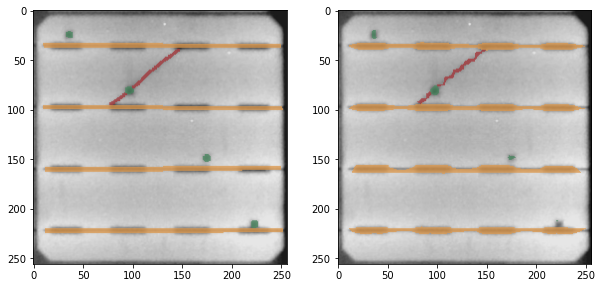

In [30]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.imshow(combo_true)

plt.subplot(1,2,2)
plt.imshow(combo_pred)

## Evaluate

In [35]:
manual_masks_val = [valset_inference.__getitem__(inx)[1].numpy() for inx in range(valset_inference.__len__())]
manual_masks_val

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [37]:
pred_masks_val

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

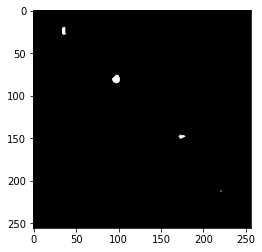

In [49]:
plt.imshow(pred_masks_val[35]==3, 'gray')

In [60]:
def separate_masks(masks, name_map=['busbar', 'crack', 'cross', 'dark']):
    masks_dict = {}

    for i, name in enumerate(name_map):
        mask = masks == (i+1) # bg is 0 so add 1
        mask = mask.astype(int)
        if mask.sum():
            masks_dict[name] = mask
    return masks_dict

In [65]:
manual_masks_val_mono = [separate_masks(mask) for mask in manual_masks_val]
pred_masks_val_mono = [separate_masks(mask) for mask in pred_masks_val]

In [67]:
def get_overall_f1(tps, fns, fps):
    return 2 * np.sum(tps) / (2 * np.sum(tps) + np.sum(fns) + np.sum(fps))

def get_overall_iou(tps, fns, fps):
    return np.sum(tps) / (np.sum(tps) + np.sum(fns) + np.sum(fps))

def get_overall_precision(tps, fps):
    return np.sum(tps) / (np.sum(tps) + np.sum(fps))

def get_overall_recall(tps, fns):
    return np.sum(tps) / (np.sum(tps) + np.sum(fns))

def get_intersection(truth, pred):
    return np.sum(truth * pred)

def get_intersection_union(truth, pred):
    intersection = np.sum(truth * pred)
    union = np.sum(truth) + np.sum(pred) - intersection

    return [intersection, union]

def get_false(mask):
    return np.sum(mask)

In [75]:
def get_overall_tf(masks_manual_all, masks_pred_all, category="crack"):
    tps = []
    fps = []
    fns = []

    for inx in range(len(masks_manual_all)):

        masks_manual = masks_manual_all[inx]
        masks_pred = masks_pred_all[inx]

        item = category
        if item not in masks_manual and item in masks_pred:
            tps.append(0)
            fns.append(0)
            fps.append(get_false(masks_pred[item]))
        elif item in masks_manual and item not in masks_pred:
            tps.append(0)
            fps.append(0)
            fns.append(get_false(masks_manual[item]))
        elif item not in masks_manual and item not in masks_pred:
            tps.append(0)
            fps.append(0)
            fns.append(0)
    
        else:
            tps.append(get_intersection(masks_manual[item], masks_pred[item]))
            fps.append(get_false(masks_pred[item]) - get_intersection(masks_manual[item], masks_pred[item]))
            fns.append(get_false(masks_manual[item]) - get_intersection(masks_manual[item], masks_pred[item]))

    return tps, fps, fns

In [78]:
def get_report_df(masks_manual_all, masks_pred_all):
    report = {}
    for key in ["crack", "busbar", "cross", "dark"]:
        tps, fps, fns = get_overall_tf(masks_manual_all, masks_pred_all, key)
        report[key] = [get_overall_precision(tps, fps), get_overall_recall(tps, fns), get_overall_f1(tps, fns, fps), get_overall_iou(tps, fns, fps)]

    report_df = pd.DataFrame.from_dict(report, orient="index", columns=["precision", "recall", "f1", "iou"])
    report_df.loc["macro"] = report_df.mean()
    return report_df


In [80]:
deeplab_report = get_report_df(manual_masks_val_mono, pred_masks_val_mono)
deeplab_report

,precision,recall,f1,iou
crack,0.644035,0.579807,0.610236,0.439093
busbar,0.846822,0.893097,0.869344,0.768885
cross,0.753885,0.642041,0.693482,0.530787
dark,0.898319,0.942719,0.919984,0.851824
macro,0.785765,0.764416,0.773261,0.647647


In [81]:
deeplab_report.to_pickle('deeplab_report_val.pkl')